In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv


df = pd.read_csv('../Datasets/processed_data.csv')
df_advertiser = pd.read_csv('../Datasets/advertiser_embeddings.csv')
df_keywords = pd.read_csv('../Datasets/keyword_embeddings.csv')
df_search_tags = pd.read_csv('../Datasets/search_tag_embeddings.csv')



In [1]:
df = pd.concat([df, df_advertiser, df_keywords, df_search_tags], axis=1)


NameError: name 'pd' is not defined

In [ ]:
# The corresponding click values for each record
engagement_value = torch.tensor(df['engagement_score'].values, dtype=torch.float).view(-1)

# Ensure shapes are appropriate
print(f"engagement shape: {engagement_value.shape}")

engagement shape: torch.Size([58930])


In [ ]:
# Initialize HeteroData object
data = HeteroData()

campaign_data = df[['campaign_index','no_of_days']]
# Convert to tensor format
campaign_features = torch.tensor(campaign_data.values, dtype=torch.float)
# data['campaign'] is the campaign node feature storage
data['campaign'].x = campaign_features


platform_data = df[['DV360', 'Facebook Ads', 'Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features


channel_data = df[['Display', 'Mobile', 
                   'Search', 'Social', 'Video']]
# Convert to tensor format
channel_features = torch.tensor(channel_data.values, dtype=torch.float)
# data['channel'] is the channel node feature storage
data['channel'].x = channel_features


creative_data = df[['has_image']]
# Convert to tensor format
creative_features = torch.tensor(creative_data.values, dtype=torch.float)
# data['creative'] is the creative node feature storage
data['creative'].x = creative_features


keyword_data = df[[f'keyword_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
keyword_features = torch.tensor(keyword_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['keywords'].x = keyword_features


advertiser_id = df[['advertiser_id']].values  # (69,000, 1)
advertiser_data = df[[f'advertiser_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Concatenate advertiser_id with the embeddings -> Resulting shape (69,000, 51)
advertiser_features = torch.tensor(np.hstack((advertiser_id, advertiser_data)), dtype=torch.float)
# Assign to the advertiser node in your graph
data['advertiser'].x = advertiser_features


search_tags_data = df[[f'search_tag_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
search_tag_features = torch.tensor(search_tags_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['search_tag'].x = search_tag_features

template_data = df[['template_id']]
# Convert to tensor format
template_features = torch.tensor(template_data.values, dtype=torch.float)
# data['template'] is the template node feature storage
data['template'].x = template_features

network_data = df[['network_id']]
# Convert to tensor format
network_features = torch.tensor(network_data.values, dtype=torch.float)
# data['network'] is the network node feature storage
data['network'].x = network_features

In [ ]:

# Edges (Campaign → Platform)
data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # platform indices
], dtype=torch.long)


data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Campaign → Channel)
data['campaign', 'uses', 'channel'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # channel indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Platform → channel)
data['platform', 'supports', 'channel'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # channel indices
], dtype=torch.long)


# Edges (Campaign → Creative)
data['campaign', 'uses', 'creative'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)

data['creative', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)

# Edges (Creative → Template)
data['creative', 'designed_with', 'template'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # template indices
], dtype=torch.long)


data['campaign', 'associated_with', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['keywords', 'rev_associated_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # channel indices
    [0, 1]   # campaign indices
], dtype=torch.long)    


data['platform', 'optimized_for', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign', 'managed_by', 'network'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign','belongs_to','advertiser'].edge_index = torch.tensor([
    [0, 1],
    [0, 1]
], dtype=torch.long)

# Edges (Campaign → Search Tag)
data['campaign', 'targeted_with', 'search_tag'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # search tag indices
], dtype=torch.long)

data['search_tag', 'rev_targeted_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # search tag indices
    [0, 1]   # campaign indices
], dtype=torch.long)


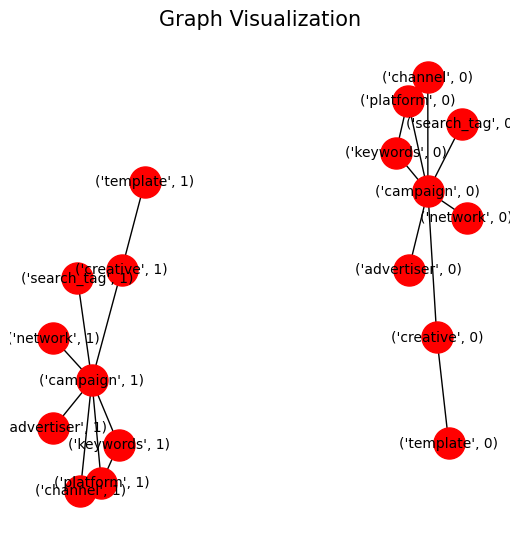

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

def visualize_graph(data):
    # Create a new graph using NetworkX
    G = nx.Graph()

    # Add nodes and edges to the graph
    for edge_type, edge_index in data.edge_index_dict.items():
        src_type, _, dst_type = edge_type  # Extract source and destination node types
        for src, dst in edge_index.t().tolist():  # Add edges to the graph
            # Add nodes as (node_type, node_id)
            G.add_node((src_type, src))
            G.add_node((dst_type, dst))
            G.add_edge((src_type, src), (dst_type, dst))
    
    # Position nodes using the spring layout (force-directed layout)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', font_size=10)
    plt.title("Graph Visualization", fontsize=15)
    plt.show()

# Visualize the graph
visualize_graph(data)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv, Linear

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class HeteroGCN(nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels):
        super(HeteroGCN, self).__init__()
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        
        # Define convolution layers for all relations in metadata
        relations = metadata[1]
        print("Relations:", relations)
        print("Metadata:", metadata)

        conv_layers = {rel: SAGEConv(in_channels=-1, out_channels=hidden_channels) for rel in relations}
        
        self.conv1 = HeteroConv(conv_layers, aggr="mean")
        self.conv2 = HeteroConv(conv_layers, aggr="mean")
        self.conv3 = HeteroConv(conv_layers, aggr="mean")
        
        # Linear transformation layer for output
        self.lin = Linear(hidden_channels, out_channels)
        
        # Normalize layers
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.norm2 = nn.LayerNorm(hidden_channels)
        self.norm3 = nn.LayerNorm(hidden_channels)
    
    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(self.norm1(x)) for key, x in x_dict.items()}
        
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(self.norm2(x)) for key, x in x_dict.items()}
        
        x_dict = self.conv3(x_dict, edge_index_dict)
        x_dict = {key: F.relu(self.norm3(x)) for key, x in x_dict.items()}
        
        # Dynamically combine node features instead of hardcoding
        x_combined = torch.cat([x for x in x_dict.values()], dim=1)
        
        return self.lin(x_combined)


In [ ]:
# Training Loop (classification)
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# Assuming target labels are available and are integers representing classes
target_labels = engagement_value.float()  # Ensure labels are integers for classification

# Get indices for campaigns (assuming 'campaign' nodes are being predicted)
campaign_indices = torch.arange(data.x_dict['campaign'].size(0))

# 80% Train, 20% Test Split
train_idx, test_idx = train_test_split(campaign_indices.cpu().numpy(), test_size=0.2, random_state=42)

# Convert to tensors
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
test_idx = torch.tensor(test_idx, dtype=torch.long, device=device)

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import StepLR

# Normalize node features
scaler = StandardScaler()
for key in data.x_dict.keys():
    data.x_dict[key] = torch.tensor(scaler.fit_transform(data.x_dict[key].cpu().numpy()), dtype=torch.float32, device=device)

# Initialize model with metadata
model = HeteroGCN(metadata=data.metadata(), hidden_channels=32, out_channels=1).to(device)

# Define optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)

num_epochs = 100
best_mse = float('inf')

train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(data.x_dict, data.edge_index_dict)['campaign']  # Extract campaign node embeddings

    # Compute Huber loss
    train_loss = F.smooth_l1_loss(out[train_idx], engagement_value[train_idx])
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_out = model(data.x_dict, data.edge_index_dict)['campaign']
        test_loss = F.smooth_l1_loss(test_out[test_idx], engagement_value[test_idx])

    test_losses.append(test_loss.item())

    print(f"Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    # Update LR scheduler
    scheduler.step()


Relations: [('campaign', 'hosted_on', 'platform'), ('platform', 'rev_hosted_on', 'campaign'), ('campaign', 'uses', 'channel'), ('channel', 'rev_uses', 'campaign'), ('platform', 'supports', 'channel'), ('campaign', 'uses', 'creative'), ('creative', 'rev_uses', 'campaign'), ('creative', 'designed_with', 'template'), ('campaign', 'associated_with', 'keywords'), ('keywords', 'rev_associated_with', 'campaign'), ('platform', 'optimized_for', 'keywords'), ('campaign', 'managed_by', 'network'), ('campaign', 'belongs_to', 'advertiser'), ('campaign', 'targeted_with', 'search_tag'), ('search_tag', 'rev_targeted_with', 'campaign')]
Metadata: (['campaign', 'platform', 'channel', 'creative', 'keywords', 'advertiser', 'search_tag', 'template', 'network'], [('campaign', 'hosted_on', 'platform'), ('platform', 'rev_hosted_on', 'campaign'), ('campaign', 'uses', 'channel'), ('channel', 'rev_uses', 'campaign'), ('platform', 'supports', 'channel'), ('campaign', 'uses', 'creative'), ('creative', 'rev_uses', 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (58930x32 and 2x32)

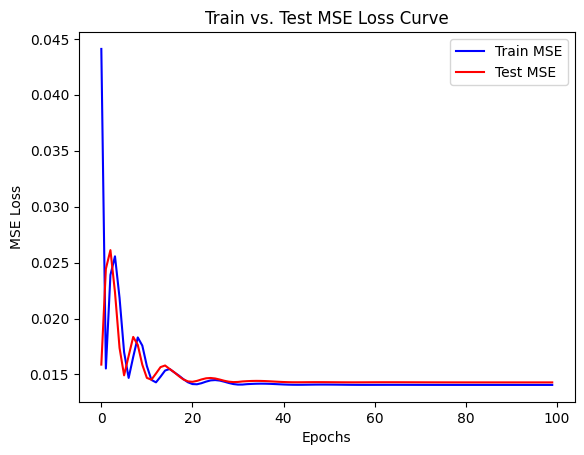

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label="Train MSE", color='blue')
plt.plot(range(len(test_losses)), test_losses, label="Test MSE", color='red')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Train vs. Test MSE Loss Curve")
plt.show()


In [ ]:
import torch.nn.functional as F

def evaluate_model(model, data, engagement_value, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation during evaluation
        # Move data to the correct device
        data = data.to(device)
        engagement_value = engagement_value.to(device)
        # Forward pass
        out = model(data.x_dict, data.edge_index_dict)
        # Ensure shapes match
        out = out[test_idx]
        engagement_value = engagement_value[test_idx]
        # Compute MSE loss between predictions and actual click values
        mse = F.mse_loss(out, engagement_value)  
        return mse.item()
    
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
mse_score = evaluate_model(model, data, engagement_value, device)
print(f"Test MSE: {mse_score:.4f}")


Test MSE: 0.0286


In [ ]:
import torch
import torch.nn.functional as F

def r_squared(y_true, y_pred):
    """Calculate the R² (coefficient of determination) score."""
    # Move tensors to CPU and convert to numpy arrays
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    
    # Compute the total sum of squares and residual sum of squares
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    
    print(f"SS_Total: {ss_tot}, SS_Res: {ss_res}")


    # Return R² score with safeguard against division by zero
    return 1 - (ss_res / (ss_tot + 1e-8))

# Ensure the model is in evaluation mode
model.eval()

# Move model and data to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data = data.to(device)
engagengagement_value =engagement_value.to(device)

with torch.no_grad():
    # Forward pass on the full dataset
    predictions = model(data.x_dict, data.edge_index_dict)
    predictions = predictions.squeeze()
    y_true =engagement_value.view(-1)
    
    # Apply test indices to avoid data leakage
    predictions = predictions[test_idx]
    y_true = y_true[test_idx]

    # Optional: Check for shape consistency
    assert predictions.shape == y_true.shape, f"Shape mismatch: {predictions.shape} vs {y_true.shape}"

    

# Compute R² score
r2_score = r_squared(y_true, predictions)
print(f"Test R²: {r2_score:.4f}")


SS_Total: 336.3308410644531, SS_Res: 336.8464660644531
Test R²: -0.0015


In [ ]:
print(f"Sample y_true: {y_true[:10]}")
print(f"Sample Predictions: {predictions[:10]}")


Sample y_true: tensor([0.1448, 0.4138, 0.1021, 0.4652, 0.6312, 0.3927, 0.6202, 0.2999, 0.6198,
        0.0932])
Sample Predictions: tensor([0.3902, 0.3886, 0.3995, 0.3791, 0.4087, 0.3787, 0.3798, 0.3747, 0.3713,
        0.3787])


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv

# Assuming your model is defined as 'model'
# and you've already prepared the new graph (with updated node features and edges)

# New data for prediction (single data point)
new_campaign = torch.tensor([[1000, 3]], dtype=torch.float)  # Single new campaign feature (1 new campaign)

new_platform = torch.tensor([[0, 1, 0]], dtype=torch.float)  # Single new platform feature (1 new platform)

new_channel = torch.tensor([[0, 0, 0, 0, 1]], dtype=torch.float)  # Single new channel feature (1 new channel)

new_creative = torch.tensor([[1]], dtype=torch.float)  # Single new creative feature (1 new creative)

new_template = torch.tensor([[91]], dtype=torch.float)  # Single new template feature (1 new template)

new_network = torch.tensor([[190]], dtype=torch.float)  # Single new network feature (1 new network)

new_keywords = torch.rand((1, 50), dtype=torch.float)  # Single new keywords feature (1 new keywords)

new_advertiser = torch.rand((1, 51), dtype=torch.float)  # Single new advertiser feature (1 new advertiser)

new_search_tag = torch.rand((1, 50), dtype=torch.float)  # Single new advertiser feature (1 new advertiser)


# Add the new nodes and their features to the graph
data['campaign'].x = torch.cat([data['campaign'].x, new_campaign], dim=0)
data['platform'].x = torch.cat([data['platform'].x, new_platform], dim=0)
data['channel'].x = torch.cat([data['channel'].x, new_channel], dim=0)
data['creative'].x = torch.cat([data['creative'].x, new_creative], dim=0)
data['template'].x = torch.cat([data['template'].x, new_template], dim=0)
data['network'].x = torch.cat([data['network'].x, new_network], dim=0)
data['keywords'].x = torch.cat([data['keywords'].x, new_keywords], dim=0)
data['advertiser'].x = torch.cat([data['advertiser'].x, new_advertiser], dim=0)
data['search_tag'].x = torch.cat([data['search_tag'].x, new_search_tag], dim=0)

new_campaign_index = data['campaign'].x.size(0) - 1
new_platform_index = data['platform'].x.size(0) - 1
new_channel_index = data['channel'].x.size(0) - 1
new_creative_index = data['creative'].x.size(0) - 1
new_template_index = data['template'].x.size(0) - 1
new_network_index = data['network'].x.size(0) - 1
new_keywords_index = data['keywords'].x.size(0) - 1
new_advertiser_index = data['advertiser'].x.size(0) - 1
new_search_tag_index = data['search_tag'].x.size(0) - 1

# # Prepare new edges if necessary (e.g., new connections between the new campaign and existing platforms, etc.)
# # Example: adding edges for the new campaign (connect to existing platforms)
# new_campaign_index = torch.tensor([data['campaign'].x.size(0) - 1])  # Index for the new campaign
# new_platform_index = torch.tensor([0])  # Platform index to connect the new campaign to

data['campaign', 'hosted_on', 'platform'].edge_index = torch.cat(
    [data['campaign', 'hosted_on', 'platform'].edge_index,
     torch.tensor([[new_campaign_index], [new_platform_index]], dtype=torch.long)], dim=1
)

data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.cat(
    [data['platform', 'rev_hosted_on', 'campaign'].edge_index,
     torch.tensor([[new_platform_index], [new_campaign_index]], dtype=torch.long)], dim=1
)

data['campaign', 'uses', 'channel'].edge_index = torch.cat(
    [data['campaign', 'uses', 'channel'].edge_index,
     torch.tensor([[new_campaign_index], [new_channel_index]], dtype=torch.long)], dim=1
)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.cat(
    [data['channel', 'rev_uses', 'campaign'].edge_index,
     torch.tensor([[new_channel_index], [new_campaign_index]], dtype=torch.long)], dim=1
)

data['platform', 'supports', 'channel'].edge_index = torch.cat(
    [data['platform', 'supports', 'channel'].edge_index,
     torch.tensor([[new_platform_index], [new_channel_index]], dtype=torch.long)], dim=1
)


data['campaign', 'uses', 'creative'].edge_index = torch.cat(
    [data['campaign', 'uses', 'creative'].edge_index,
     torch.tensor([[new_campaign_index], [new_creative_index]], dtype=torch.long)], dim=1
)

data['creative', 'designed_with', 'template'].edge_index = torch.cat(
    [data['creative', 'designed_with', 'template'].edge_index,
     torch.tensor([[new_creative_index], [new_template_index]], dtype=torch.long)], dim=1
)

data['campaign', 'associated_with', 'keywords'].edge_index = torch.cat(
    [data['campaign', 'associated_with', 'keywords'].edge_index,
     torch.tensor([[new_campaign_index], [new_keywords_index]], dtype=torch.long)], dim=1
)

data['campaign', 'managed_by', 'network'].edge_index = torch.cat(
    [data['campaign', 'managed_by', 'network'].edge_index,
     torch.tensor([[new_campaign_index], [new_network_index]], dtype=torch.long)], dim=1
)

data['platform', 'optimized_for', 'keywords'].edge_index = torch.cat(
    [data['platform', 'optimized_for', 'keywords'].edge_index,
     torch.tensor([[new_platform_index], [new_keywords_index]], dtype=torch.long)], dim=1
)

data['campaign', 'belongs_to', 'advertiser'].edge_index = torch.cat(
    [data['campaign', 'belongs_to', 'advertiser'].edge_index,
     torch.tensor([[new_campaign_index], [new_advertiser_index]], dtype=torch.long)], dim=1
)

data['campaign', 'targeted_with', 'search_tag'].edge_index = torch.cat(
    [data['campaign', 'targeted_with', 'search_tag'].edge_index,
     torch.tensor([[new_campaign_index], [new_search_tag_index]], dtype=torch.long)], dim=1
)


data['search_tag', 'rev_targeted_with', 'campaign'].edge_index = torch.cat(
    [data['search_tag', 'rev_targeted_with', 'campaign'].edge_index,
     torch.tensor([[new_campaign_index], [new_search_tag_index]], dtype=torch.long)], dim=1
)


In [ ]:
# Run model inference
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)

new_campaign_pred = output[-1]  # Assuming last row corresponds to the new campaign
print("Predicted clicks for new campaign:", new_campaign_pred.item())

Predicted clicks for new campaign: 0.48223328590393066


In [ ]:
# Run model inference
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)
    print("Shape of output:", output.shape)


new_campaign_pred = output[-1]  # Assuming last row corresponds to the new campaign
print("Predicted clicks for new campaign:", new_campaign_pred.item())


Shape of output: torch.Size([58931])
Predicted clicks for new campaign: 0.48223328590393066


In [ ]:
print("First 10 predictions:\n", output[:10])
print("Output shape:", output.shape)
print("Number of campaign nodes:", len(data.x_dict['campaign']))


First 10 predictions:
 tensor([0.2948, 0.4290, 0.3996, 0.4063, 0.4079, 0.4027, 0.4088, 0.3936, 0.3982,
        0.4144])
Output shape: torch.Size([58931])
Number of campaign nodes: 58931


In [ ]:
# print("Last campaign features in dataset:", data.x_dict['campaign'][-1])
# print("New campaign features:", new_campaign_features)  # Replace with actual feature tensor


In [ ]:
torch.save(model.state_dict(), "sage_model.pth")  # ✅ Save only weights
